In [1]:
import numpy as np
import cfml.misc
import cfml.transform
import cfml.bayes

In [2]:
data_provider = cfml.misc.Lab4DataProvider(r"C:\Programing\sem6\ml\lab4\data").load()

In [3]:
def message_transform(msg: cfml.misc.Message, *transformers):
    obj = msg.subject + msg.content
    for transformer in transformers:
        obj = transformer(obj)
    return (obj, msg.label)

In [4]:
folds_by_n = dict()
transformers_by_n = dict()
for n in range(1, 4):
    hashable_to_int = cfml.bayes.HashableToIntTransformer()
    transformers_by_n[n] = (cfml.transform.NGramsTransformer(n), lambda x: list(map(hashable_to_int, x)))
    folds_by_n[n] = data_provider.apply_transformer(lambda msg: message_transform(msg, *transformers_by_n[n]))

In [5]:
def accuracy(nn, _np, pn, pp):
    # print(nn, _np, pn, pp)
    return (nn + pp) / (nn + _np + pn + pp)

In [6]:
ln_lambda_legit_bounds = (-500, -200)
ln_alpha_bounds = (-20, 0)

def count_accuracy(ln_lambda_legit, ln_alpha, folds, classifiers):
    nn, _np, pn, pp = 0, 0, 0, 0
    for i, classifier in enumerate(classifiers):
        classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
        classifier.alpha = np.exp(ln_alpha)
        for msg in folds[i]:
            y_pred = classifier(msg[0], hard=True)
            y_real = msg[1]   
            if y_pred == 0.0:
                if y_real == 0.0:
                    nn += 1
                else:
                    pn += 1
            else:
                if y_real == 0.0:
                    _np += 1
                else:
                    pp += 1
    return accuracy(nn, _np, pn, pp)

def accuracy_target(trial, folds, classifiers):
    ln_lambda_legit = trial.suggest_float("ln_lambda_legit", *ln_lambda_legit_bounds)
    ln_alpha = trial.suggest_float("ln_alpha", *ln_alpha_bounds)
    return count_accuracy(ln_lambda_legit, ln_alpha, folds, classifiers)
   

In [7]:
classifiers_by_n = dict()

for n in range(1, 4):
    classifiers_by_n[n] = []
    for i in range(len(folds_by_n[n])):
        train = []
        for j in range(len(folds_by_n[n])):
            if i != j:
                train += folds_by_n[n][j]
        
        X_train, Y_train = [], []
        for msg in train:
            X_train.append(msg[0])
            Y_train.append(msg[1])
            
        classifiers_by_n[n].append(cfml.bayes.NaiveBayesClassifier(X_train, Y_train))

In [8]:
import optuna

def best_study(n, trials=100):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: accuracy_target(trial, folds_by_n[n], classifiers_by_n[n]), n_trials=trials)
    return study

def bruteforce(n):
    pass

In [9]:
studies = [best_study(i) for i in range(1, 4)]

[I 2022-05-17 20:41:26,390] A new study created in memory with name: no-name-38ee26dc-6d04-4b20-94ae-56c6525c1c8d
[I 2022-05-17 20:41:30,733] Trial 0 finished with value: 0.5321100917431193 and parameters: {'ln_lambda_legit': -462.082705649452, 'ln_alpha': -3.13101409462827}. Best is trial 0 with value: 0.5321100917431193.
[I 2022-05-17 20:41:34,980] Trial 1 finished with value: 0.6807339449541284 and parameters: {'ln_lambda_legit': -408.83033570391444, 'ln_alpha': -9.861469780251271}. Best is trial 1 with value: 0.6807339449541284.
[I 2022-05-17 20:41:39,267] Trial 2 finished with value: 0.7394495412844037 and parameters: {'ln_lambda_legit': -228.2706219926331, 'ln_alpha': -5.719143757405787}. Best is trial 2 with value: 0.7394495412844037.
[I 2022-05-17 20:41:43,510] Trial 3 finished with value: 0.7568807339449541 and parameters: {'ln_lambda_legit': -450.9929467168064, 'ln_alpha': -19.52502787995211}. Best is trial 3 with value: 0.7568807339449541.
[I 2022-05-17 20:41:47,707] Trial 4

In [10]:
best_value = 0.0
best_lambda_legit, best_alpha, best_n = None, None, None

for n, study in enumerate(studies):
    print("best accuracy for n =", n + 1, "is", study.best_value, "with params" + str(study.best_params))
    if best_value < study.best_value:
        best_value = study.best_value
        best_n = n + 1
        best_lambda_legit = np.exp(study.best_params["ln_lambda_legit"])
        best_alpha = np.exp(study.best_params["ln_alpha"])

print("overall best accuracy", best_value, " for lambda_legit", best_lambda_legit, ", alpha", best_alpha, "n", best_n)

best accuracy for n = 1 is 0.9036697247706422 with params{'ln_lambda_legit': -200.21335040687677, 'ln_alpha': -19.156102428328033}
best accuracy for n = 2 is 0.9779816513761468 with params{'ln_lambda_legit': -218.92829230131687, 'ln_alpha': -19.9908900375513}
best accuracy for n = 3 is 0.9761467889908257 with params{'ln_lambda_legit': -200.39178123877915, 'ln_alpha': -15.156588535376393}
overall best accuracy 0.9779816513761468  for lambda_legit 8.330109706262316e-96 , alpha 2.0800164438833213e-09 n 2


In [11]:
def count_accuracy_1(test_fold, classifier):
    nn, _np, pn, pp = 0, 0, 0, 0
    for msg in test_fold:
        y_pred = classifier(msg[0], hard=True)
        y_real = msg[1]   
        if y_pred == 0.0:
            if y_real == 0.0:
                nn += 1
            else:
                pn += 1
        else:
            if y_real == 0.0:
                _np += 1
            else:
                pp += 1
    return accuracy(nn, _np, pn, pp)

In [12]:
best_classifier = classifiers_by_n[best_n][0]
folds = folds_by_n[best_n]
test_fold = folds_by_n[best_n][0]
best_classifier.lambdas = (best_lambda_legit, 1.0)
best_classifier.alpha = best_alpha

In [13]:
count_accuracy_1(test_fold, best_classifier)

0.9724770642201835

In [14]:
from collections import namedtuple
import matplotlib.pyplot as plt

IndexProbLabel = namedtuple("IndexProbLabel", ("index", "prob", "y_real"))

def roc_auc(classifier, test_fold):
    objs = []
    cnt_spam, cnt_legit = 0, 0
    for i, msg in enumerate(test_fold):
        y_spam_prob = classifier(msg[0])[1]
        objs.append(IndexProbLabel(i, y_spam_prob, msg[1]))
        if msg[1] == 1.0:
            cnt_spam += 1
        else:
            cnt_legit += 1
    # print(cnt_spam, cnt_legit)
    objs.sort(key=lambda x: x.prob)
    
    step_x = 1.0 / cnt_spam
    step_y = 1.0 / cnt_legit
    xs = []
    ys = []
    x, y = 0, 0
    
    auc = 0.0
    
    def up():
        nonlocal x
        nonlocal y
        xs.append(x)
        ys.append(y)
        y += step_y
    
    def right():
        nonlocal x
        nonlocal y
        nonlocal auc
        xs.append(x)
        ys.append(y)
        x += step_x
        auc += step_x * ys[-1]

    for obj in objs:
        if obj.y_real == 1.0:
            right()
        else:
            up()
    
    plt.plot(xs, ys)
    plt.show()
    
    return auc

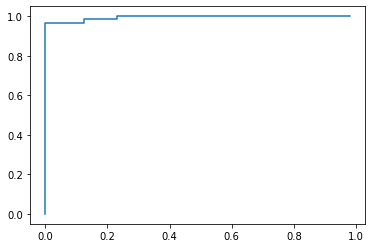

0.9941939890710397

In [15]:
roc_auc(best_classifier, test_fold)

In [16]:
ln_lambda_legit_bounds_1 = ln_lambda_legit_bounds

def count_fp(folds, classifier):
    fp = 0
    for i in range(len(folds)):
        for msg in folds[i]:
            y_pred = classifier(msg[0], hard=True)
            y_real = msg[1]
            if y_pred == 1.0 and y_real == 0.0:
                fp += 1
    return fp

def false_positive_minimize_target(trial, folds, classifier):
    ln_lambda_legit = trial.suggest_float("ln_lambda_legit", *ln_lambda_legit_bounds_1)
    classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
    return count_fp(folds, classifier)

In [17]:
def best_study_min_fp(trials=1000):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: false_positive_minimize_target(trial, (test_fold, ), best_classifier), n_trials=trials)
    return study

In [18]:
def bruteforce():
    best = count_fp(folds, best_classifier)
    b_lambda_legit = np.log(best_lambda_legit)
    ln_lambda_legit = np.log(best_lambda_legit)
    for _ in range(400):
        ln_lambda_legit += 1
        best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
        result = count_fp(folds, best_classifier)
        
        if result < best:
            best = result
            b_lambda_legit = ln_lambda_legit
            
            if result == 0.0:
                break
        
        print(ln_lambda_legit, "\t", result, "\t", best, "\t", b_lambda_legit)
    return b_lambda_legit

In [19]:
lambda_legit_0fp = np.exp(bruteforce())

-217.92829230131687 	 3 	 3 	 -218.92829230131687
-216.92829230131687 	 3 	 3 	 -218.92829230131687
-215.92829230131687 	 3 	 3 	 -218.92829230131687
-214.92829230131687 	 3 	 3 	 -218.92829230131687
-213.92829230131687 	 3 	 3 	 -218.92829230131687
-212.92829230131687 	 3 	 3 	 -218.92829230131687
-211.92829230131687 	 3 	 3 	 -218.92829230131687
-210.92829230131687 	 3 	 3 	 -218.92829230131687
-209.92829230131687 	 3 	 3 	 -218.92829230131687
-208.92829230131687 	 3 	 3 	 -218.92829230131687
-207.92829230131687 	 3 	 3 	 -218.92829230131687
-206.92829230131687 	 3 	 3 	 -218.92829230131687
-205.92829230131687 	 3 	 3 	 -218.92829230131687
-204.92829230131687 	 3 	 3 	 -218.92829230131687
-203.92829230131687 	 3 	 3 	 -218.92829230131687
-202.92829230131687 	 3 	 3 	 -218.92829230131687
-201.92829230131687 	 2 	 2 	 -201.92829230131687
-200.92829230131687 	 2 	 2 	 -201.92829230131687
-199.92829230131687 	 2 	 2 	 -201.92829230131687
-198.92829230131687 	 2 	 2 	 -201.92829230131687


In [20]:
best_classifier.lambdas = (np.exp(lambda_legit_0fp), 1.0)
print(lambda_legit_0fp, count_accuracy_1(test_fold, best_classifier))

1.7943326384646876e-05 0.981651376146789


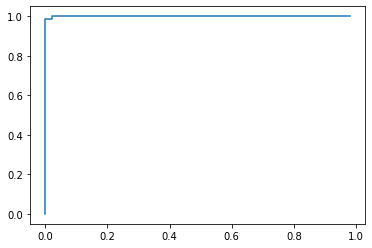

0.9996584699453566

In [21]:
roc_auc(best_classifier, test_fold)

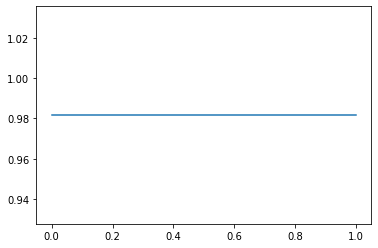

In [23]:
xs = np.linspace(lambda_legit_0fp, 1.0, num=60)
ys = []
for x in xs:
    best_classifier.lambdas = (np.exp(x), 1.0)
    ys.append(count_accuracy_1(test_fold, best_classifier))

plt.plot(xs, ys)
plt.show()

In [24]:
best_classifier1 = classifiers_by_n[best_n][1]
best_classifier1.lambdas = (np.exp(lambda_legit_0fp), 1.0)
best_classifier1.alpha = best_alpha

In [26]:
count_accuracy_1(folds_by_n[2][1], best_classifier1)

0.9908256880733946